In [1]:
import os
import random
import sys
import glob
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
input_duration=3
# % pylab inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading the Data

In [3]:
# Data Directory
# Please edit according to your directory change.
fp = "/content/drive/MyDrive/Audio24"
dir_list = os.listdir(fp)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir( "/content/drive/MyDrive/Audio24/" + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path =  r"/content/drive/MyDrive/Audio24/" + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])

        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1

        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [5]:
print (len(data_df))
data_df.head(25)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,1
1,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,0,0,5
2,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,7
3,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,4
4,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,1,5
5,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,0,0,1
6,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,1,7
7,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,2
8,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,4
9,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,5


## Plotting the audio file's waveform and its spectrogram

In [6]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/drive/MyDrive/Audio24/Actor_18/03-01-04-01-01-02-18.wav


(22050,
 array([ 2.2503092e-10, -2.4656163e-10,  2.5696184e-10, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32))

In [7]:
len(samples), sample_rate

(80195, 22050)

In [8]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [9]:
sample_rate/ len(samples)

0.2749547976806534

Text(0.5, 0, 'Seconds')

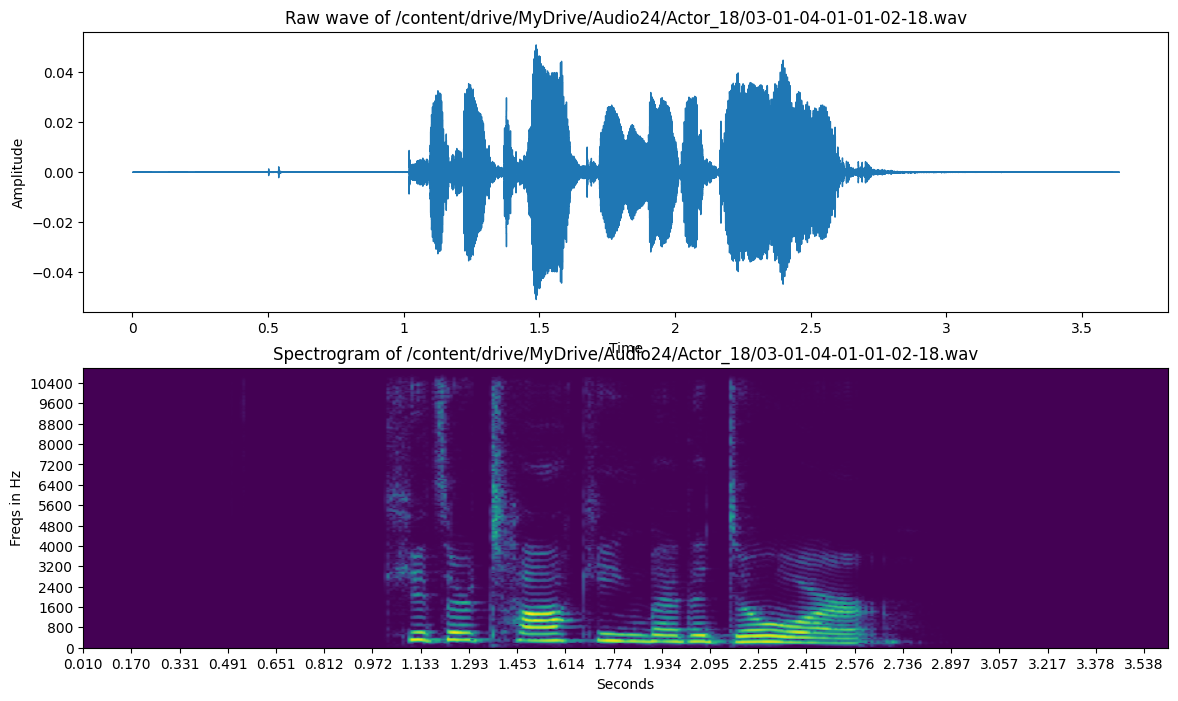

In [10]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [11]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [12]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 4.0475788e-07, -1.9560787e-07, -4.7045035e-08, ...,
         3.4845256e-05, -7.2393537e-05, -7.7592616e-05], dtype=float32),
 array([22016, 60928]))

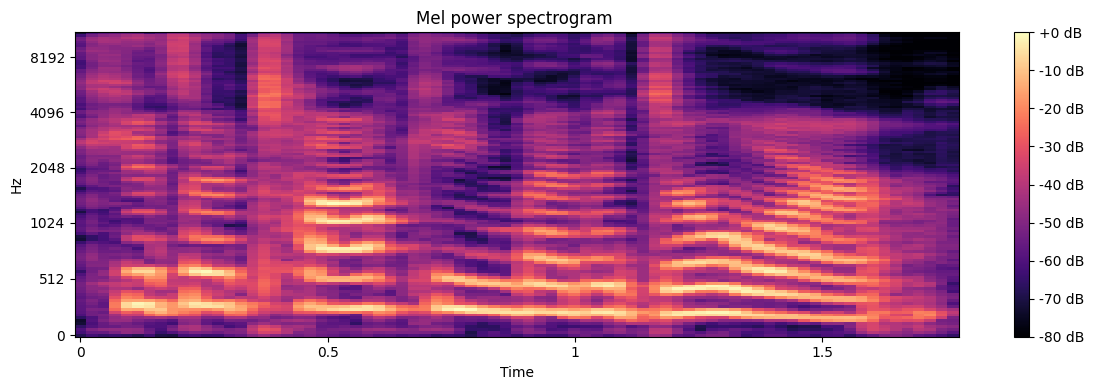

In [13]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

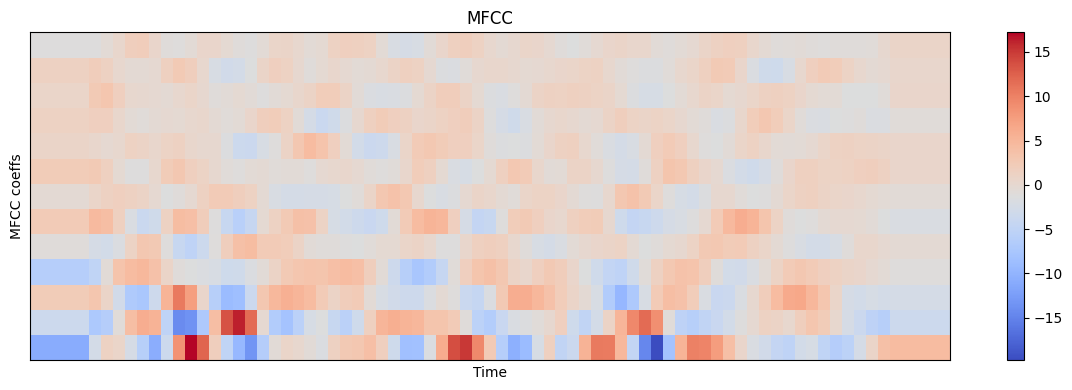

In [14]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [15]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [16]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [17]:
# Silence trimmed Sound by manual trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

## Defining the label

In [18]:


label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"

    label2_list.append(data_df.gender[i] + lb)

len(label2_list)

1440

In [19]:


label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"

    # Add gender to the label
    label3_list.append(data_df.gender[i] + lb)

len(label3_list)

1440

In [20]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    else:
        lb = "_none"

    # Add gender to the label
    label5_list.append(data_df.gender[i] + lb)

len(label5_list)

1440

In [21]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"

    # Add gender to the label
    label8_list.append(data_df.gender[i]  + lb)

len(label8_list)

1440

In [22]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label5_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
#data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,1,male_none
1,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,0,0,5,male_angry
2,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,7,male_none
3,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,4,male_sad
4,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,1,5,male_angry


In [23]:
# Creating my own dataframe for testing for my  own audio
c=0
my_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'intensity', 'statement', 'repetition', 'emotion'])
path='/content/drive/MyDrive/Audio24/Actor_01/03-01-01-01-01-01-01.wav'
nm = path.split('.')[0].split('-')

src = int(nm[1])
actor = int(nm[-1])
emotion = int(nm[2])
if int(actor)%2 == 0:
  gender = "female"
else:
  gender = "male"
if nm[3] == '01':
  intensity = 0
else:
  intensity = 1
if nm[4] == '01':
  statement = 0
else:
  statement = 1
if nm[5] == '01':
  repeat = 0
else:
  repeat = 1
my_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
count+=1
my_df["label"] ="male_sad"
my_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
1440,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,0,0,1,male_sad


In [24]:
data_df=data_df.append(my_df)

<ipython-input-24-cfdaa076a14b>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [25]:
print (data_df.label.value_counts().keys())

Index(['male_none', 'female_none', 'male_sad', 'male_angry', 'male_calm',
       'male_happy', 'male_fearful', 'female_fearful', 'female_angry',
       'female_sad', 'female_happy', 'female_calm'],
      dtype='object')


In [26]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count.
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

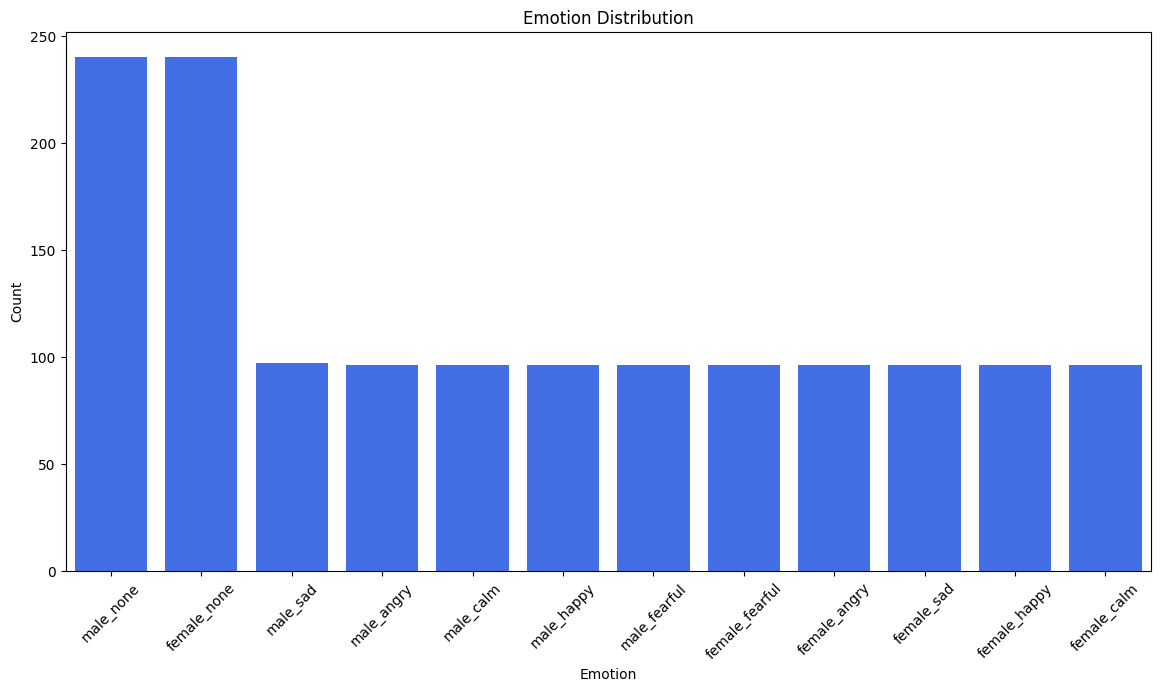

In [27]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

## Data Splitting

In [28]:
# Male Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head(50)

401


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,0,0,5,male_angry
1,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,4,male_sad
2,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,1,5,male_angry
3,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,2,male_calm
4,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,4,male_sad
5,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,0,5,male_angry
6,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,1,1,5,male_angry
7,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,3,male_happy
8,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,1,0,1,2,male_calm
9,/content/drive/MyDrive/Audio24/Actor_01/03-01-...,1,1,male,0,1,0,5,male_angry


In [29]:

#Remember the index number for testing out
data2_df.query('actor==25')

,path,source,actor,gender,intensity,statement,repetition,emotion,label


In [30]:
print (len(data3_df))
data3_df.head(80)

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Audio24/Actor_21/03-01-...,1,21,male,0,1,0,3,male_happy
1,/content/drive/MyDrive/Audio24/Actor_21/03-01-...,1,21,male,1,0,1,5,male_angry
2,/content/drive/MyDrive/Audio24/Actor_21/03-01-...,1,21,male,1,1,1,2,male_calm
3,/content/drive/MyDrive/Audio24/Actor_21/03-01-...,1,21,male,0,1,1,5,male_angry
4,/content/drive/MyDrive/Audio24/Actor_21/03-01-...,1,21,male,0,0,0,3,male_happy
...,...,...,...,...,...,...,...,...,...
75,/content/drive/MyDrive/Audio24/Actor_23/03-01-...,1,23,male,1,1,1,5,male_angry
76,/content/drive/MyDrive/Audio24/Actor_23/03-01-...,1,23,male,1,1,1,2,male_calm
77,/content/drive/MyDrive/Audio24/Actor_23/03-01-...,1,23,male,0,0,0,5,male_angry
78,/content/drive/MyDrive/Audio24/Actor_23/03-01-...,1,23,male,0,0,1,4,male_sad


## Analysing Features of audio files using librosa

> Indented block

> Indented block





In [31]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i] ,duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    print(mfccs.shape)
    feature = mfccs
    data.loc[i] = [feature]

  0%|          | 1/401 [00:00<03:51,  1.73it/s]

(259,)


  0%|          | 2/401 [00:01<03:40,  1.81it/s]

(259,)


  1%|          | 3/401 [00:01<03:44,  1.77it/s]

(259,)


  1%|          | 4/401 [00:02<03:50,  1.73it/s]

(259,)


  1%|          | 5/401 [00:02<03:47,  1.74it/s]

(259,)


  1%|▏         | 6/401 [00:03<03:54,  1.68it/s]

(259,)


  2%|▏         | 7/401 [00:04<03:56,  1.66it/s]

(259,)


  2%|▏         | 8/401 [00:04<03:54,  1.67it/s]

(259,)


  2%|▏         | 9/401 [00:05<04:01,  1.63it/s]

(259,)


  2%|▏         | 10/401 [00:05<03:54,  1.67it/s]

(259,)


  3%|▎         | 11/401 [00:06<03:48,  1.71it/s]

(259,)


  3%|▎         | 12/401 [00:06<03:39,  1.77it/s]

(259,)


  3%|▎         | 13/401 [00:07<03:39,  1.76it/s]

(259,)


  3%|▎         | 14/401 [00:08<03:34,  1.80it/s]

(253,)


  4%|▎         | 15/401 [00:08<03:42,  1.73it/s]

(259,)


  4%|▍         | 16/401 [00:09<03:37,  1.77it/s]

(259,)


  4%|▍         | 17/401 [00:10<04:09,  1.54it/s]

(259,)


  4%|▍         | 18/401 [00:10<04:05,  1.56it/s]

(259,)


  5%|▍         | 19/401 [00:11<03:56,  1.62it/s]

(259,)


  5%|▍         | 20/401 [00:11<03:49,  1.66it/s]

(259,)


  5%|▌         | 21/401 [00:12<03:45,  1.68it/s]

(259,)


  5%|▌         | 22/401 [00:12<03:37,  1.74it/s]

(259,)


  6%|▌         | 23/401 [00:13<03:30,  1.79it/s]

(256,)


  6%|▌         | 24/401 [00:14<03:30,  1.79it/s]

(259,)


  6%|▌         | 25/401 [00:14<03:35,  1.75it/s]

(248,)


  6%|▋         | 26/401 [00:15<03:34,  1.75it/s]

(259,)


  7%|▋         | 27/401 [00:15<03:37,  1.72it/s]

(256,)


  7%|▋         | 28/401 [00:16<03:48,  1.63it/s]

(259,)


  7%|▋         | 29/401 [00:17<03:52,  1.60it/s]

(256,)


  7%|▋         | 30/401 [00:17<03:52,  1.59it/s]

(259,)


  8%|▊         | 31/401 [00:18<03:56,  1.57it/s]

(259,)


  8%|▊         | 32/401 [00:19<03:50,  1.60it/s]

(259,)


  8%|▊         | 33/401 [00:19<03:51,  1.59it/s]

(259,)


  8%|▊         | 34/401 [00:20<03:52,  1.58it/s]

(259,)


  9%|▊         | 35/401 [00:21<04:07,  1.48it/s]

(259,)


  9%|▉         | 36/401 [00:21<04:27,  1.37it/s]

(259,)


  9%|▉         | 37/401 [00:22<04:11,  1.45it/s]

(259,)


  9%|▉         | 38/401 [00:23<04:03,  1.49it/s]

(259,)


 10%|▉         | 39/401 [00:23<03:52,  1.56it/s]

(259,)


 10%|▉         | 40/401 [00:24<03:44,  1.61it/s]

(259,)


 10%|█         | 41/401 [00:24<03:37,  1.66it/s]

(233,)


 10%|█         | 42/401 [00:25<03:31,  1.70it/s]

(259,)


 11%|█         | 43/401 [00:26<03:32,  1.68it/s]

(242,)


 11%|█         | 44/401 [00:26<03:32,  1.68it/s]

(259,)


 11%|█         | 45/401 [00:27<03:26,  1.73it/s]

(259,)


 11%|█▏        | 46/401 [00:27<03:34,  1.66it/s]

(259,)


 12%|█▏        | 47/401 [00:28<03:34,  1.65it/s]

(253,)


 12%|█▏        | 48/401 [00:28<03:25,  1.72it/s]

(242,)


 12%|█▏        | 49/401 [00:29<03:19,  1.77it/s]

(259,)


 12%|█▏        | 50/401 [00:30<03:13,  1.81it/s]

(259,)


 13%|█▎        | 51/401 [00:30<03:09,  1.84it/s]

(256,)


 13%|█▎        | 52/401 [00:31<03:04,  1.89it/s]

(259,)


 13%|█▎        | 53/401 [00:31<03:02,  1.91it/s]

(259,)


 13%|█▎        | 54/401 [00:32<03:03,  1.89it/s]

(259,)


 14%|█▎        | 55/401 [00:32<03:05,  1.87it/s]

(259,)


 14%|█▍        | 56/401 [00:33<02:59,  1.92it/s]

(259,)


 14%|█▍        | 57/401 [00:33<03:03,  1.88it/s]

(259,)


 14%|█▍        | 58/401 [00:34<03:11,  1.79it/s]

(259,)


 15%|█▍        | 59/401 [00:34<03:10,  1.79it/s]

(259,)


 15%|█▍        | 60/401 [00:35<03:11,  1.78it/s]

(259,)


 15%|█▌        | 61/401 [00:35<03:09,  1.80it/s]

(259,)


 15%|█▌        | 62/401 [00:36<03:03,  1.85it/s]

(259,)


 16%|█▌        | 63/401 [00:37<03:04,  1.83it/s]

(259,)


 16%|█▌        | 64/401 [00:37<03:04,  1.83it/s]

(259,)


 16%|█▌        | 65/401 [00:38<02:59,  1.87it/s]

(259,)


 16%|█▋        | 66/401 [00:38<03:03,  1.83it/s]

(259,)


 17%|█▋        | 67/401 [00:39<03:00,  1.85it/s]

(259,)


 17%|█▋        | 68/401 [00:39<02:59,  1.86it/s]

(259,)


 17%|█▋        | 69/401 [00:40<02:54,  1.90it/s]

(259,)


 17%|█▋        | 70/401 [00:40<02:52,  1.92it/s]

(259,)


 18%|█▊        | 71/401 [00:41<02:54,  1.89it/s]

(259,)


 18%|█▊        | 72/401 [00:41<02:50,  1.92it/s]

(259,)


 18%|█▊        | 73/401 [00:42<02:47,  1.96it/s]

(259,)


 18%|█▊        | 74/401 [00:42<02:56,  1.86it/s]

(259,)


 19%|█▊        | 75/401 [00:43<02:51,  1.90it/s]

(259,)


 19%|█▉        | 76/401 [00:43<02:53,  1.87it/s]

(259,)


 19%|█▉        | 77/401 [00:44<02:53,  1.86it/s]

(259,)


 19%|█▉        | 78/401 [00:44<02:47,  1.93it/s]

(259,)


 20%|█▉        | 79/401 [00:45<02:51,  1.88it/s]

(259,)


 20%|█▉        | 80/401 [00:46<02:49,  1.89it/s]

(259,)


 20%|██        | 81/401 [00:46<02:49,  1.88it/s]

(236,)


 20%|██        | 82/401 [00:47<02:49,  1.88it/s]

(248,)


 21%|██        | 83/401 [00:47<02:51,  1.85it/s]

(259,)


 21%|██        | 84/401 [00:48<02:47,  1.89it/s]

(259,)


 21%|██        | 85/401 [00:48<02:47,  1.89it/s]

(251,)


 21%|██▏       | 86/401 [00:49<02:49,  1.86it/s]

(259,)


 22%|██▏       | 87/401 [00:49<02:47,  1.87it/s]

(259,)


 22%|██▏       | 88/401 [00:50<02:47,  1.87it/s]

(251,)


 22%|██▏       | 89/401 [00:50<02:44,  1.90it/s]

(259,)


 22%|██▏       | 90/401 [00:51<02:40,  1.93it/s]

(259,)


 23%|██▎       | 91/401 [00:51<02:38,  1.95it/s]

(236,)


 23%|██▎       | 92/401 [00:52<02:38,  1.94it/s]

(225,)


 23%|██▎       | 93/401 [00:52<02:43,  1.89it/s]

(228,)


 23%|██▎       | 94/401 [00:53<02:57,  1.73it/s]

(239,)


 24%|██▎       | 95/401 [00:54<02:49,  1.81it/s]

(259,)


 24%|██▍       | 96/401 [00:54<03:00,  1.69it/s]

(248,)


 24%|██▍       | 97/401 [00:55<02:55,  1.73it/s]

(259,)


 24%|██▍       | 98/401 [00:55<02:51,  1.77it/s]

(225,)


 25%|██▍       | 99/401 [00:56<02:47,  1.80it/s]

(259,)


 25%|██▍       | 100/401 [00:56<02:44,  1.83it/s]

(259,)


 25%|██▌       | 101/401 [00:57<02:38,  1.89it/s]

(239,)


 25%|██▌       | 102/401 [00:57<02:37,  1.90it/s]

(259,)


 26%|██▌       | 103/401 [00:58<02:34,  1.93it/s]

(236,)


 26%|██▌       | 104/401 [00:58<02:32,  1.94it/s]

(259,)


 26%|██▌       | 105/401 [00:59<02:34,  1.92it/s]

(259,)


 26%|██▋       | 106/401 [01:00<02:39,  1.85it/s]

(259,)


 27%|██▋       | 107/401 [01:00<02:36,  1.88it/s]

(259,)


 27%|██▋       | 108/401 [01:01<02:39,  1.84it/s]

(222,)


 27%|██▋       | 109/401 [01:01<02:34,  1.89it/s]

(228,)


 27%|██▋       | 110/401 [01:02<02:36,  1.87it/s]

(239,)


 28%|██▊       | 111/401 [01:02<02:34,  1.88it/s]

(259,)


 28%|██▊       | 112/401 [01:03<02:38,  1.83it/s]

(259,)


 28%|██▊       | 113/401 [01:03<02:41,  1.78it/s]

(259,)


 28%|██▊       | 114/401 [01:04<02:47,  1.71it/s]

(228,)


 29%|██▊       | 115/401 [01:05<02:45,  1.73it/s]

(259,)


 29%|██▉       | 116/401 [01:05<02:40,  1.77it/s]

(259,)


 29%|██▉       | 117/401 [01:06<03:04,  1.54it/s]

(259,)


 29%|██▉       | 118/401 [01:07<02:55,  1.61it/s]

(259,)


 30%|██▉       | 119/401 [01:07<02:46,  1.69it/s]

(259,)


 30%|██▉       | 120/401 [01:08<02:43,  1.72it/s]

(259,)


 30%|███       | 121/401 [01:08<02:37,  1.78it/s]

(259,)


 30%|███       | 122/401 [01:09<02:36,  1.79it/s]

(259,)


 31%|███       | 123/401 [01:09<02:38,  1.76it/s]

(259,)


 31%|███       | 124/401 [01:10<02:34,  1.79it/s]

(259,)


 31%|███       | 125/401 [01:10<02:31,  1.82it/s]

(259,)


 31%|███▏      | 126/401 [01:11<02:29,  1.84it/s]

(259,)


 32%|███▏      | 127/401 [01:11<02:26,  1.87it/s]

(253,)


 32%|███▏      | 128/401 [01:12<02:24,  1.88it/s]

(259,)


 32%|███▏      | 129/401 [01:13<02:38,  1.72it/s]

(259,)


 32%|███▏      | 130/401 [01:13<02:38,  1.71it/s]

(248,)


 33%|███▎      | 131/401 [01:14<02:30,  1.80it/s]

(259,)


 33%|███▎      | 132/401 [01:14<02:27,  1.82it/s]

(259,)


 33%|███▎      | 133/401 [01:15<02:25,  1.85it/s]

(259,)


 33%|███▎      | 134/401 [01:15<02:22,  1.87it/s]

(259,)


 34%|███▎      | 135/401 [01:16<02:25,  1.83it/s]

(259,)


 34%|███▍      | 136/401 [01:16<02:22,  1.86it/s]

(259,)


 34%|███▍      | 137/401 [01:17<02:20,  1.88it/s]

(259,)


 34%|███▍      | 138/401 [01:17<02:24,  1.82it/s]

(259,)


 35%|███▍      | 139/401 [01:18<02:20,  1.86it/s]

(259,)


 35%|███▍      | 140/401 [01:19<02:21,  1.85it/s]

(259,)


 35%|███▌      | 141/401 [01:19<02:34,  1.68it/s]

(259,)


 35%|███▌      | 142/401 [01:20<02:29,  1.74it/s]

(259,)


 36%|███▌      | 143/401 [01:20<02:25,  1.78it/s]

(251,)


 36%|███▌      | 144/401 [01:21<02:23,  1.79it/s]

(256,)


 36%|███▌      | 145/401 [01:21<02:20,  1.83it/s]

(251,)


 36%|███▋      | 146/401 [01:22<02:18,  1.84it/s]

(259,)


 37%|███▋      | 147/401 [01:23<02:26,  1.74it/s]

(259,)


 37%|███▋      | 148/401 [01:23<02:21,  1.78it/s]

(259,)


 37%|███▋      | 149/401 [01:24<02:23,  1.76it/s]

(253,)


 37%|███▋      | 150/401 [01:24<02:18,  1.81it/s]

(259,)


 38%|███▊      | 151/401 [01:25<02:15,  1.84it/s]

(256,)


 38%|███▊      | 152/401 [01:25<02:12,  1.88it/s]

(259,)


 38%|███▊      | 153/401 [01:26<02:10,  1.90it/s]

(256,)


 38%|███▊      | 154/401 [01:26<02:09,  1.90it/s]

(251,)


 39%|███▊      | 155/401 [01:27<02:10,  1.88it/s]

(259,)


 39%|███▉      | 156/401 [01:27<02:12,  1.85it/s]

(259,)


 39%|███▉      | 157/401 [01:28<02:08,  1.90it/s]

(259,)


 39%|███▉      | 158/401 [01:28<02:09,  1.87it/s]

(259,)


 40%|███▉      | 159/401 [01:29<02:08,  1.88it/s]

(259,)


 40%|███▉      | 160/401 [01:30<02:25,  1.66it/s]

(259,)


 40%|████      | 161/401 [01:30<02:18,  1.73it/s]

(256,)


 40%|████      | 162/401 [01:31<02:34,  1.55it/s]

(259,)


 41%|████      | 163/401 [01:32<02:23,  1.66it/s]

(230,)


 41%|████      | 164/401 [01:32<02:21,  1.67it/s]

(259,)


 41%|████      | 165/401 [01:33<02:18,  1.71it/s]

(228,)


 41%|████▏     | 166/401 [01:33<02:13,  1.77it/s]

(259,)


 42%|████▏     | 167/401 [01:34<02:14,  1.74it/s]

(239,)


 42%|████▏     | 168/401 [01:34<02:11,  1.77it/s]

(259,)


 42%|████▏     | 169/401 [01:35<02:11,  1.76it/s]

(259,)


 42%|████▏     | 170/401 [01:35<02:07,  1.81it/s]

(259,)


 43%|████▎     | 171/401 [01:36<02:04,  1.85it/s]

(259,)


 43%|████▎     | 172/401 [01:36<02:01,  1.89it/s]

(259,)


 43%|████▎     | 173/401 [01:37<01:59,  1.91it/s]

(236,)


 43%|████▎     | 174/401 [01:37<01:57,  1.93it/s]

(259,)


 44%|████▎     | 175/401 [01:38<01:57,  1.93it/s]

(245,)


 44%|████▍     | 176/401 [01:38<01:56,  1.93it/s]

(230,)


 44%|████▍     | 177/401 [01:39<01:55,  1.95it/s]

(259,)


 44%|████▍     | 178/401 [01:40<01:57,  1.90it/s]

(242,)


 45%|████▍     | 179/401 [01:40<01:54,  1.94it/s]

(245,)


 45%|████▍     | 180/401 [01:41<01:53,  1.95it/s]

(259,)


 45%|████▌     | 181/401 [01:41<01:51,  1.97it/s]

(245,)


 45%|████▌     | 182/401 [01:42<01:53,  1.93it/s]

(253,)


 46%|████▌     | 183/401 [01:42<01:51,  1.95it/s]

(251,)


 46%|████▌     | 184/401 [01:43<01:50,  1.96it/s]

(228,)


 46%|████▌     | 185/401 [01:43<01:50,  1.96it/s]

(259,)


 46%|████▋     | 186/401 [01:44<01:50,  1.94it/s]

(259,)


 47%|████▋     | 187/401 [01:44<01:49,  1.95it/s]

(253,)


 47%|████▋     | 188/401 [01:45<01:47,  1.98it/s]

(236,)


 47%|████▋     | 189/401 [01:45<01:51,  1.91it/s]

(236,)


 47%|████▋     | 190/401 [01:46<01:51,  1.90it/s]

(245,)


 48%|████▊     | 191/401 [01:46<01:49,  1.92it/s]

(259,)


 48%|████▊     | 192/401 [01:47<01:51,  1.87it/s]

(259,)


 48%|████▊     | 193/401 [01:47<01:53,  1.83it/s]

(256,)


 48%|████▊     | 194/401 [01:48<01:52,  1.83it/s]

(259,)


 49%|████▊     | 195/401 [01:48<01:52,  1.84it/s]

(259,)


 49%|████▉     | 196/401 [01:49<01:53,  1.81it/s]

(251,)


 49%|████▉     | 197/401 [01:50<01:52,  1.82it/s]

(239,)


 49%|████▉     | 198/401 [01:50<01:52,  1.81it/s]

(259,)


 50%|████▉     | 199/401 [01:51<01:54,  1.77it/s]

(259,)


 50%|████▉     | 200/401 [01:51<01:55,  1.74it/s]

(259,)


 50%|█████     | 201/401 [01:52<01:50,  1.80it/s]

(256,)


 50%|█████     | 202/401 [01:52<01:47,  1.85it/s]

(259,)


 51%|█████     | 203/401 [01:53<01:45,  1.87it/s]

(245,)


 51%|█████     | 204/401 [01:53<01:42,  1.92it/s]

(233,)


 51%|█████     | 205/401 [01:54<01:41,  1.93it/s]

(259,)


 51%|█████▏    | 206/401 [01:54<01:42,  1.90it/s]

(256,)


 52%|█████▏    | 207/401 [01:55<01:41,  1.91it/s]

(259,)


 52%|█████▏    | 208/401 [01:55<01:40,  1.93it/s]

(230,)


 52%|█████▏    | 209/401 [01:56<01:42,  1.87it/s]

(259,)


 52%|█████▏    | 210/401 [01:57<01:50,  1.73it/s]

(259,)


 53%|█████▎    | 211/401 [01:57<01:45,  1.81it/s]

(259,)


 53%|█████▎    | 212/401 [01:58<01:41,  1.86it/s]

(236,)


 53%|█████▎    | 213/401 [01:58<01:39,  1.89it/s]

(259,)


 53%|█████▎    | 214/401 [01:59<01:42,  1.82it/s]

(245,)


 54%|█████▎    | 215/401 [01:59<01:40,  1.86it/s]

(245,)


 54%|█████▍    | 216/401 [02:00<01:42,  1.81it/s]

(259,)


 54%|█████▍    | 217/401 [02:00<01:39,  1.85it/s]

(259,)


 54%|█████▍    | 218/401 [02:01<01:35,  1.91it/s]

(245,)


 55%|█████▍    | 219/401 [02:01<01:35,  1.90it/s]

(248,)


 55%|█████▍    | 220/401 [02:02<01:37,  1.85it/s]

(259,)


 55%|█████▌    | 221/401 [02:03<01:41,  1.77it/s]

(259,)


 55%|█████▌    | 222/401 [02:03<01:44,  1.71it/s]

(245,)


 56%|█████▌    | 223/401 [02:04<01:39,  1.78it/s]

(259,)


 56%|█████▌    | 224/401 [02:04<01:37,  1.82it/s]

(233,)


 56%|█████▌    | 225/401 [02:05<01:37,  1.80it/s]

(225,)


 56%|█████▋    | 226/401 [02:05<01:35,  1.83it/s]

(259,)


 57%|█████▋    | 227/401 [02:06<01:39,  1.74it/s]

(259,)


 57%|█████▋    | 228/401 [02:07<01:36,  1.79it/s]

(230,)


 57%|█████▋    | 229/401 [02:07<01:33,  1.84it/s]

(233,)


 57%|█████▋    | 230/401 [02:08<01:32,  1.84it/s]

(253,)


 58%|█████▊    | 231/401 [02:08<01:31,  1.86it/s]

(256,)


 58%|█████▊    | 232/401 [02:09<01:29,  1.88it/s]

(233,)


 58%|█████▊    | 233/401 [02:09<01:28,  1.89it/s]

(222,)


 58%|█████▊    | 234/401 [02:10<01:28,  1.89it/s]

(259,)


 59%|█████▊    | 235/401 [02:10<01:28,  1.88it/s]

(239,)


 59%|█████▉    | 236/401 [02:11<01:25,  1.92it/s]

(259,)


 59%|█████▉    | 237/401 [02:11<01:25,  1.92it/s]

(259,)


 59%|█████▉    | 238/401 [02:12<01:25,  1.90it/s]

(259,)


 60%|█████▉    | 239/401 [02:12<01:25,  1.89it/s]

(259,)


 60%|█████▉    | 240/401 [02:13<01:24,  1.90it/s]

(228,)


 60%|██████    | 241/401 [02:13<01:31,  1.75it/s]

(228,)


 60%|██████    | 242/401 [02:14<01:29,  1.78it/s]

(253,)


 61%|██████    | 243/401 [02:15<01:25,  1.85it/s]

(253,)


 61%|██████    | 244/401 [02:15<01:24,  1.85it/s]

(236,)


 61%|██████    | 245/401 [02:16<01:27,  1.79it/s]

(242,)


 61%|██████▏   | 246/401 [02:16<01:25,  1.82it/s]

(228,)


 62%|██████▏   | 247/401 [02:17<01:22,  1.87it/s]

(259,)


 62%|██████▏   | 248/401 [02:17<01:20,  1.90it/s]

(230,)


 62%|██████▏   | 249/401 [02:18<01:25,  1.78it/s]

(245,)


 62%|██████▏   | 250/401 [02:18<01:22,  1.82it/s]

(259,)


 63%|██████▎   | 251/401 [02:19<01:21,  1.85it/s]

(259,)


 63%|██████▎   | 252/401 [02:19<01:20,  1.86it/s]

(248,)


 63%|██████▎   | 253/401 [02:20<01:19,  1.87it/s]

(259,)


 63%|██████▎   | 254/401 [02:20<01:19,  1.85it/s]

(242,)


 64%|██████▎   | 255/401 [02:21<01:17,  1.88it/s]

(230,)


 64%|██████▍   | 256/401 [02:22<01:22,  1.75it/s]

(233,)


 64%|██████▍   | 257/401 [02:22<01:20,  1.80it/s]

(210,)


 64%|██████▍   | 258/401 [02:23<01:24,  1.70it/s]

(233,)


 65%|██████▍   | 259/401 [02:23<01:21,  1.75it/s]

(259,)


 65%|██████▍   | 260/401 [02:24<01:18,  1.80it/s]

(259,)


 65%|██████▌   | 261/401 [02:24<01:16,  1.83it/s]

(253,)


 65%|██████▌   | 262/401 [02:25<01:14,  1.86it/s]

(239,)


 66%|██████▌   | 263/401 [02:25<01:13,  1.89it/s]

(233,)


 66%|██████▌   | 264/401 [02:26<01:11,  1.91it/s]

(259,)


 66%|██████▌   | 265/401 [02:27<01:16,  1.77it/s]

(259,)


 66%|██████▋   | 266/401 [02:27<01:14,  1.80it/s]

(228,)


 67%|██████▋   | 267/401 [02:28<01:15,  1.79it/s]

(248,)


 67%|██████▋   | 268/401 [02:28<01:14,  1.78it/s]

(216,)


 67%|██████▋   | 269/401 [02:29<01:13,  1.80it/s]

(233,)


 67%|██████▋   | 270/401 [02:29<01:11,  1.83it/s]

(219,)


 68%|██████▊   | 271/401 [02:30<01:09,  1.87it/s]

(245,)


 68%|██████▊   | 272/401 [02:30<01:08,  1.88it/s]

(233,)


 68%|██████▊   | 273/401 [02:31<01:08,  1.87it/s]

(253,)


 68%|██████▊   | 274/401 [02:32<01:09,  1.82it/s]

(248,)


 69%|██████▊   | 275/401 [02:32<01:07,  1.86it/s]

(236,)


 69%|██████▉   | 276/401 [02:33<01:08,  1.84it/s]

(228,)


 69%|██████▉   | 277/401 [02:33<01:06,  1.86it/s]

(248,)


 69%|██████▉   | 278/401 [02:34<01:05,  1.88it/s]

(259,)


 70%|██████▉   | 279/401 [02:34<01:11,  1.71it/s]

(233,)


 70%|██████▉   | 280/401 [02:35<01:07,  1.78it/s]

(259,)


 70%|███████   | 281/401 [02:35<01:06,  1.81it/s]

(259,)


 70%|███████   | 282/401 [02:36<01:03,  1.87it/s]

(259,)


 71%|███████   | 283/401 [02:36<01:03,  1.86it/s]

(253,)


 71%|███████   | 284/401 [02:37<01:03,  1.84it/s]

(259,)


 71%|███████   | 285/401 [02:38<01:03,  1.83it/s]

(248,)


 71%|███████▏  | 286/401 [02:38<01:03,  1.83it/s]

(253,)


 72%|███████▏  | 287/401 [02:39<01:05,  1.75it/s]

(259,)


 72%|███████▏  | 288/401 [02:39<01:02,  1.80it/s]

(259,)


 72%|███████▏  | 289/401 [02:40<01:00,  1.84it/s]

(242,)


 72%|███████▏  | 290/401 [02:40<00:59,  1.86it/s]

(251,)


 73%|███████▎  | 291/401 [02:41<00:58,  1.88it/s]

(259,)


 73%|███████▎  | 292/401 [02:41<00:57,  1.89it/s]

(242,)


 73%|███████▎  | 293/401 [02:42<00:56,  1.92it/s]

(245,)


 73%|███████▎  | 294/401 [02:42<00:55,  1.91it/s]

(251,)


 74%|███████▎  | 295/401 [02:43<00:54,  1.93it/s]

(256,)


 74%|███████▍  | 296/401 [02:43<00:54,  1.93it/s]

(245,)


 74%|███████▍  | 297/401 [02:44<00:54,  1.90it/s]

(248,)


 74%|███████▍  | 298/401 [02:45<01:00,  1.70it/s]

(256,)


 75%|███████▍  | 299/401 [02:45<00:58,  1.73it/s]

(259,)


 75%|███████▍  | 300/401 [02:46<00:56,  1.79it/s]

(248,)


 75%|███████▌  | 301/401 [02:46<00:57,  1.74it/s]

(242,)


 75%|███████▌  | 302/401 [02:47<00:54,  1.80it/s]

(259,)


 76%|███████▌  | 303/401 [02:47<00:55,  1.78it/s]

(259,)


 76%|███████▌  | 304/401 [02:48<00:52,  1.84it/s]

(259,)


 76%|███████▌  | 305/401 [02:48<00:51,  1.85it/s]

(256,)


 76%|███████▋  | 306/401 [02:49<00:52,  1.81it/s]

(259,)


 77%|███████▋  | 307/401 [02:50<00:51,  1.81it/s]

(239,)


 77%|███████▋  | 308/401 [02:50<00:53,  1.73it/s]

(259,)


 77%|███████▋  | 309/401 [02:51<00:51,  1.80it/s]

(259,)


 77%|███████▋  | 310/401 [02:51<00:51,  1.76it/s]

(242,)


 78%|███████▊  | 311/401 [02:52<00:51,  1.74it/s]

(259,)


 78%|███████▊  | 312/401 [02:52<00:49,  1.78it/s]

(259,)


 78%|███████▊  | 313/401 [02:53<00:47,  1.85it/s]

(245,)


 78%|███████▊  | 314/401 [02:53<00:46,  1.88it/s]

(259,)


 79%|███████▊  | 315/401 [02:54<00:46,  1.86it/s]

(259,)


 79%|███████▉  | 316/401 [02:54<00:45,  1.89it/s]

(259,)


 79%|███████▉  | 317/401 [02:55<00:44,  1.88it/s]

(239,)


 79%|███████▉  | 318/401 [02:56<00:43,  1.89it/s]

(259,)


 80%|███████▉  | 319/401 [02:56<00:42,  1.92it/s]

(259,)


 80%|███████▉  | 320/401 [02:57<00:45,  1.80it/s]

(242,)


 80%|████████  | 321/401 [02:57<00:43,  1.84it/s]

(259,)


 80%|████████  | 322/401 [02:58<00:43,  1.83it/s]

(259,)


 81%|████████  | 323/401 [02:58<00:42,  1.83it/s]

(259,)


 81%|████████  | 324/401 [02:59<00:41,  1.86it/s]

(259,)


 81%|████████  | 325/401 [02:59<00:40,  1.88it/s]

(259,)


 81%|████████▏ | 326/401 [03:00<00:40,  1.83it/s]

(259,)


 82%|████████▏ | 327/401 [03:00<00:39,  1.85it/s]

(256,)


 82%|████████▏ | 328/401 [03:01<00:40,  1.79it/s]

(259,)


 82%|████████▏ | 329/401 [03:02<00:40,  1.78it/s]

(259,)


 82%|████████▏ | 330/401 [03:02<00:43,  1.65it/s]

(256,)


 83%|████████▎ | 331/401 [03:03<00:40,  1.72it/s]

(259,)


 83%|████████▎ | 332/401 [03:03<00:40,  1.72it/s]

(259,)


 83%|████████▎ | 333/401 [03:04<00:39,  1.70it/s]

(259,)


 83%|████████▎ | 334/401 [03:05<00:38,  1.73it/s]

(259,)


 84%|████████▎ | 335/401 [03:05<00:36,  1.81it/s]

(259,)


 84%|████████▍ | 336/401 [03:06<00:36,  1.80it/s]

(259,)


 84%|████████▍ | 337/401 [03:06<00:35,  1.81it/s]

(259,)


 84%|████████▍ | 338/401 [03:07<00:33,  1.86it/s]

(259,)


 85%|████████▍ | 339/401 [03:07<00:33,  1.86it/s]

(259,)


 85%|████████▍ | 340/401 [03:08<00:33,  1.83it/s]

(259,)


 85%|████████▌ | 341/401 [03:08<00:32,  1.87it/s]

(259,)


 85%|████████▌ | 342/401 [03:09<00:31,  1.87it/s]

(259,)


 86%|████████▌ | 343/401 [03:09<00:30,  1.87it/s]

(259,)


 86%|████████▌ | 344/401 [03:10<00:29,  1.93it/s]

(259,)


 86%|████████▌ | 345/401 [03:10<00:28,  1.95it/s]

(259,)


 86%|████████▋ | 346/401 [03:11<00:28,  1.96it/s]

(259,)


 87%|████████▋ | 347/401 [03:11<00:27,  1.96it/s]

(256,)


 87%|████████▋ | 348/401 [03:12<00:26,  1.97it/s]

(259,)


 87%|████████▋ | 349/401 [03:12<00:26,  1.95it/s]

(259,)


 87%|████████▋ | 350/401 [03:13<00:26,  1.93it/s]

(259,)


 88%|████████▊ | 351/401 [03:13<00:25,  1.94it/s]

(259,)


 88%|████████▊ | 352/401 [03:14<00:25,  1.89it/s]

(259,)


 88%|████████▊ | 353/401 [03:15<00:25,  1.86it/s]

(259,)


 88%|████████▊ | 354/401 [03:15<00:25,  1.88it/s]

(259,)


 89%|████████▊ | 355/401 [03:16<00:24,  1.85it/s]

(259,)


 89%|████████▉ | 356/401 [03:16<00:24,  1.84it/s]

(259,)


 89%|████████▉ | 357/401 [03:17<00:25,  1.75it/s]

(259,)


 89%|████████▉ | 358/401 [03:17<00:24,  1.79it/s]

(256,)


 90%|████████▉ | 359/401 [03:18<00:23,  1.78it/s]

(259,)


 90%|████████▉ | 360/401 [03:18<00:22,  1.81it/s]

(259,)


 90%|█████████ | 361/401 [03:19<00:21,  1.84it/s]

(259,)


 90%|█████████ | 362/401 [03:19<00:20,  1.86it/s]

(259,)


 91%|█████████ | 363/401 [03:20<00:20,  1.86it/s]

(259,)


 91%|█████████ | 364/401 [03:21<00:19,  1.85it/s]

(259,)


 91%|█████████ | 365/401 [03:21<00:19,  1.89it/s]

(259,)


 91%|█████████▏| 366/401 [03:22<00:18,  1.92it/s]

(251,)


 92%|█████████▏| 367/401 [03:22<00:17,  1.91it/s]

(259,)


 92%|█████████▏| 368/401 [03:23<00:17,  1.86it/s]

(259,)


 92%|█████████▏| 369/401 [03:23<00:16,  1.91it/s]

(259,)


 92%|█████████▏| 370/401 [03:24<00:16,  1.90it/s]

(259,)


 93%|█████████▎| 371/401 [03:24<00:15,  1.88it/s]

(259,)


 93%|█████████▎| 372/401 [03:25<00:15,  1.91it/s]

(253,)


 93%|█████████▎| 373/401 [03:25<00:14,  1.93it/s]

(259,)


 93%|█████████▎| 374/401 [03:26<00:13,  1.94it/s]

(259,)


 94%|█████████▎| 375/401 [03:26<00:14,  1.84it/s]

(239,)


 94%|█████████▍| 376/401 [03:27<00:13,  1.84it/s]

(259,)


 94%|█████████▍| 377/401 [03:27<00:13,  1.83it/s]

(259,)


 94%|█████████▍| 378/401 [03:28<00:12,  1.90it/s]

(259,)


 95%|█████████▍| 379/401 [03:28<00:11,  1.93it/s]

(259,)


 95%|█████████▍| 380/401 [03:29<00:10,  1.93it/s]

(259,)


 95%|█████████▌| 381/401 [03:30<00:10,  1.89it/s]

(256,)


 95%|█████████▌| 382/401 [03:30<00:09,  1.92it/s]

(259,)


 96%|█████████▌| 383/401 [03:31<00:10,  1.76it/s]

(259,)


 96%|█████████▌| 384/401 [03:31<00:09,  1.78it/s]

(259,)


 96%|█████████▌| 385/401 [03:32<00:08,  1.80it/s]

(259,)


 96%|█████████▋| 386/401 [03:32<00:08,  1.82it/s]

(259,)


 97%|█████████▋| 387/401 [03:33<00:08,  1.66it/s]

(259,)


 97%|█████████▋| 388/401 [03:34<00:07,  1.69it/s]

(245,)


 97%|█████████▋| 389/401 [03:34<00:06,  1.74it/s]

(259,)


 97%|█████████▋| 390/401 [03:35<00:06,  1.77it/s]

(259,)


 98%|█████████▊| 391/401 [03:35<00:05,  1.83it/s]

(259,)


 98%|█████████▊| 392/401 [03:36<00:04,  1.85it/s]

(259,)


 98%|█████████▊| 393/401 [03:36<00:04,  1.87it/s]

(259,)


 98%|█████████▊| 394/401 [03:37<00:03,  1.88it/s]

(259,)


 99%|█████████▊| 395/401 [03:37<00:03,  1.89it/s]

(259,)


 99%|█████████▉| 396/401 [03:38<00:02,  1.91it/s]

(242,)


 99%|█████████▉| 397/401 [03:38<00:02,  1.83it/s]

(259,)


 99%|█████████▉| 398/401 [03:39<00:01,  1.86it/s]

(242,)


100%|█████████▉| 399/401 [03:39<00:01,  1.85it/s]

(259,)


100%|█████████▉| 400/401 [03:40<00:00,  1.85it/s]

(230,)


100%|██████████| 401/401 [03:41<00:00,  1.81it/s]

(242,)


In [32]:
data.tail()


,feature
396,"[-45.16223, -44.393044, -45.391006, -46.17963,..."
397,"[-64.74637, -61.184513, -65.279655, -66.382996..."
398,"[-42.22599, -45.100418, -49.094578, -50.658524..."
399,"[-50.661785, -51.421227, -52.996006, -56.03267..."
400,"[-65.80266, -65.80266, -65.80266, -65.80266, -..."


In [33]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [34]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-42.993393,-42.993393,-42.847641,-42.269676,-40.691570,-40.165310,-40.074478,-42.605686,-41.734951,-41.412102,...,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393
1,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,...,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185
2,-53.999016,-53.864799,-53.554401,-53.881039,-54.018963,-54.072403,-54.130375,-54.259731,-54.264290,-54.138985,...,-50.494308,-51.436081,-53.212776,-54.072403,-54.072403,-54.072403,-54.043110,-54.015663,-54.072403,-54.072403
3,-73.256584,-73.256584,-73.256584,-73.256584,-68.776535,-69.382439,-73.256584,-73.256584,-73.256584,-73.256584,...,-50.463318,-50.857098,-55.646145,-54.590523,-53.435246,-56.296562,-57.456379,-58.768784,-59.845707,-59.075993
4,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,...,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071


In [35]:
newdf = pd.concat([df3,labels], axis=1)

In [36]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

401

In [37]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-42.993393,-42.993393,-42.847641,-42.269676,-40.691570,-40.165310,-40.074478,-42.605686,-41.734951,-41.412102,...,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,male_angry
1,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,...,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,male_sad
2,-53.999016,-53.864799,-53.554401,-53.881039,-54.018963,-54.072403,-54.130375,-54.259731,-54.264290,-54.138985,...,-51.436081,-53.212776,-54.072403,-54.072403,-54.072403,-54.043110,-54.015663,-54.072403,-54.072403,male_angry
3,-73.256584,-73.256584,-73.256584,-73.256584,-68.776535,-69.382439,-73.256584,-73.256584,-73.256584,-73.256584,...,-50.857098,-55.646145,-54.590523,-53.435246,-56.296562,-57.456379,-58.768784,-59.845707,-59.075993,male_calm
4,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,...,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,male_sad
5,-49.256630,-48.948826,-49.052872,-49.021690,-49.044888,-49.090279,-47.906372,-47.957642,-48.154175,-48.784397,...,-48.449326,-48.560356,-48.075359,-48.270229,-48.005745,-47.869633,-48.857140,-49.008034,-49.581303,male_angry
6,-40.825333,-40.786648,-40.809727,-40.877914,-40.621086,-40.421486,-40.694252,-40.932537,-40.968487,-40.789368,...,-26.739138,-29.419842,-28.893314,-29.569817,-32.071384,-33.714699,-32.312370,-31.762911,-31.615807,male_angry
7,-65.428970,-65.428970,-65.263397,-65.428970,-65.428970,-65.428970,-65.029282,-65.406113,-65.428970,-59.000870,...,-65.428970,-65.428970,-65.428970,-65.428970,-65.428970,-65.428970,-65.428970,-65.428970,-65.428970,male_happy
8,-69.244873,-69.244873,-69.244873,-69.244873,-68.903641,-67.984703,-68.090813,-67.898956,-65.259720,-67.172623,...,-57.187614,-61.190392,-67.110016,-67.509796,-66.247360,-68.734879,-69.244873,-69.244873,-69.244873,male_calm
9,-56.166710,-56.168213,-56.159485,-54.665241,-55.168388,-56.158577,-56.158577,-56.158577,-56.158577,-56.158577,...,-56.158577,-56.158577,-56.158577,-55.559196,-54.969440,-56.158577,-56.158577,-54.899796,-55.379539,male_angry


In [38]:
rnewdf.isnull().sum().sum()

2301

In [39]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-42.993393,-42.993393,-42.847641,-42.269676,-40.691570,-40.165310,-40.074478,-42.605686,-41.734951,-41.412102,...,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,male_angry
1,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,...,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,male_sad
2,-53.999016,-53.864799,-53.554401,-53.881039,-54.018963,-54.072403,-54.130375,-54.259731,-54.264290,-54.138985,...,-51.436081,-53.212776,-54.072403,-54.072403,-54.072403,-54.043110,-54.015663,-54.072403,-54.072403,male_angry
3,-73.256584,-73.256584,-73.256584,-73.256584,-68.776535,-69.382439,-73.256584,-73.256584,-73.256584,-73.256584,...,-50.857098,-55.646145,-54.590523,-53.435246,-56.296562,-57.456379,-58.768784,-59.845707,-59.075993,male_calm
4,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,...,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,male_sad


## Data Making/Processing

In [40]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):

    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'),
                                      sample_rate, n_steps=pitch_change,
                                      bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)

def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

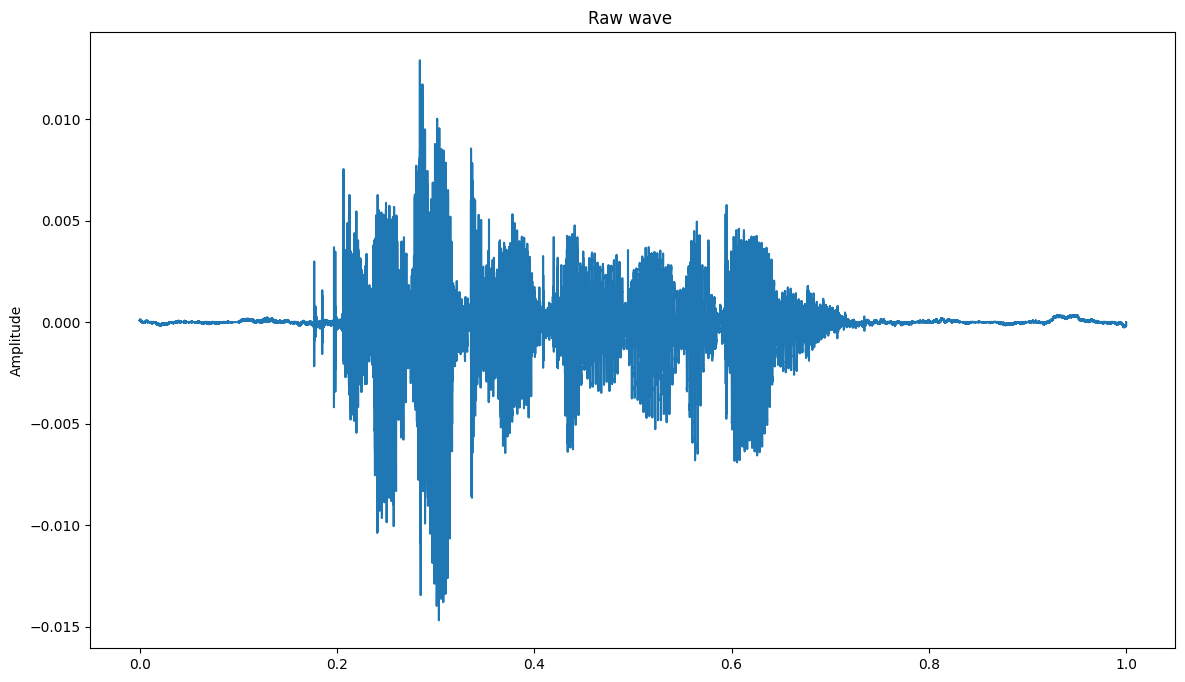

In [41]:
X, sample_rate = librosa.load(data2_df.path[216],duration=4,sr=22050*2,offset=0.3)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

In [42]:
# Data Making Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i],duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 401/401 [00:27<00:00, 14.50it/s]


In [43]:
# Data Making Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        #X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 401/401 [00:18<00:00, 21.80it/s]


In [44]:
len(syn_data1), len(syn_data2)

(401, 401)

In [45]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [46]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

401

In [47]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-42.837055,-40.357958,-38.696015,-39.779813,-38.486351,-37.068389,-36.763958,-38.953816,-38.657240,-38.071782,...,-39.656524,-39.416751,-40.817686,-40.905593,-39.690143,-39.001501,-41.044750,-41.615281,-41.367621,male_angry
1,-52.081521,-48.839453,-48.500143,-49.207045,-46.725625,-46.347743,-48.012140,-49.912877,-51.128848,-51.889234,...,-51.018392,-50.792052,-49.052722,-50.219551,-49.932873,-48.878367,-50.323571,-47.247699,-47.647356,male_sad
2,-48.798047,-44.232598,-44.150547,-46.602429,-45.964239,-46.468527,-46.609946,-44.977470,-44.371716,-44.696124,...,-44.176059,-45.356481,-47.510714,-46.877994,-44.753972,-43.940490,-44.296144,-44.242920,-47.141281,male_angry
3,-57.897924,-55.474473,-57.372384,-57.557470,-56.903089,-56.298388,-55.841916,-54.903651,-54.514999,-56.201870,...,-47.945176,-52.944918,-52.531474,-49.813061,-52.001374,-52.744694,-55.000346,-54.609529,-54.124516,male_calm
4,-55.602223,-52.533298,-53.379848,-54.236169,-52.775555,-53.626417,-55.177654,-54.578699,-53.429892,-54.305301,...,-53.115057,-54.113591,-56.267838,-54.396758,-56.291045,-54.601653,-53.049356,-54.592815,-55.896604,male_sad


In [48]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

401

In [49]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-42.993393,-42.993393,-42.847641,-42.269676,-40.691570,-40.165310,-40.074478,-42.605686,-41.734951,-41.412102,...,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,male_angry
1,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,...,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,male_sad
2,-53.999016,-53.864799,-53.554401,-53.881039,-54.018963,-54.072403,-54.130375,-54.259731,-54.264290,-54.138985,...,-51.436081,-53.212776,-54.072403,-54.072403,-54.072403,-54.043110,-54.015663,-54.072403,-54.072403,male_angry
3,-73.256584,-73.256584,-73.256584,-73.256584,-68.776535,-69.382439,-73.256584,-73.256584,-73.256584,-73.256584,...,-50.857098,-55.646145,-54.590523,-53.435246,-56.296562,-57.456379,-58.768784,-59.845707,-59.075993,male_calm
4,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,...,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,male_sad


In [50]:
# Combining the Proccessed data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-42.993393,-42.993393,-42.847641,-42.269676,-40.691570,-40.165310,-40.074478,-42.605686,-41.734951,-41.412102,...,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,-42.993393,male_angry
1,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,...,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,-62.080185,male_sad
2,-53.999016,-53.864799,-53.554401,-53.881039,-54.018963,-54.072403,-54.130375,-54.259731,-54.264290,-54.138985,...,-51.436081,-53.212776,-54.072403,-54.072403,-54.072403,-54.043110,-54.015663,-54.072403,-54.072403,male_angry
3,-73.256584,-73.256584,-73.256584,-73.256584,-68.776535,-69.382439,-73.256584,-73.256584,-73.256584,-73.256584,...,-50.857098,-55.646145,-54.590523,-53.435246,-56.296562,-57.456379,-58.768784,-59.845707,-59.075993,male_calm
4,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,...,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,-70.231071,male_sad


In [51]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [52]:
X_train.shape

(962, 259)

In [53]:
y_train.value_counts()

male_sad        194
male_happy      192
male_calm       192
male_fearful    192
male_angry      192
Name: label, dtype: int64

In [54]:
y_test.value_counts()

male_sad        49
male_happy      48
male_fearful    48
male_calm       48
male_angry      48
Name: label, dtype: int64

In [55]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [56]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [57]:
X_train

array([[-52.45283024, -51.89249944, -54.18113071, ..., -53.41853428,
        -51.98412304, -52.07560018],
       [-67.67949677, -67.36997223, -71.01138306, ..., -42.43792725,
        -43.78245544, -45.73876572],
       [-66.12975311, -59.34210587, -58.44916534, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-48.06311417, -48.06311417, -47.75089264, ..., -48.06311417,
        -47.80799103, -47.79252625],
       [-35.01678535, -33.00027014, -35.79197044, ...,   0.        ,
          0.        ,   0.        ],
       [-26.42116906, -26.9789768 , -28.05289395, ..., -29.95180614,
        -29.49970933, -28.65953196]])

In [58]:
X_train.shape

(962, 259)

## Creating the CNN Model

In [59]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [60]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [61]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 252, 256)          2304      
                                                                 
 activation (Activation)     (None, 252, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 256)          524544    
                                                                 
 batch_normalization (Batch  (None, 252, 256)          1024      
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 252, 256)          0         
                                                                 
 dropout (Dropout)           (None, 252, 256)          0         
                                                        

In [63]:
# Compile your model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [64]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/drive/My Drive/Project/Data_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=50,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.4152 - accuracy: 0.3659

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



61/61 [==============================] - 35s 508ms/step - loss: 1.4152 - accuracy: 0.3659 - val_loss: 3.2321 - val_accuracy: 0.2614 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 32s 524ms/step - loss: 1.2903 - accuracy: 0.4397 - val_loss: 1.6975 - val_accuracy: 0.3651 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 29s 479ms/step - loss: 1.2659 - accuracy: 0.4906 - val_loss: 1.3392 - val_accuracy: 0.4191 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 28s 457ms/step - loss: 1.1936 - accuracy: 0.5021 - val_loss: 1.3085 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 29s 483ms/step - loss: 1.1915 - accuracy: 0.5000 - val_loss: 1.6447 - val_accuracy: 0.3776 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 31s 503ms/step - loss: 1.1322 - accuracy: 0.5447 - val_loss: 1.2881 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 30s 484ms/step - loss: 

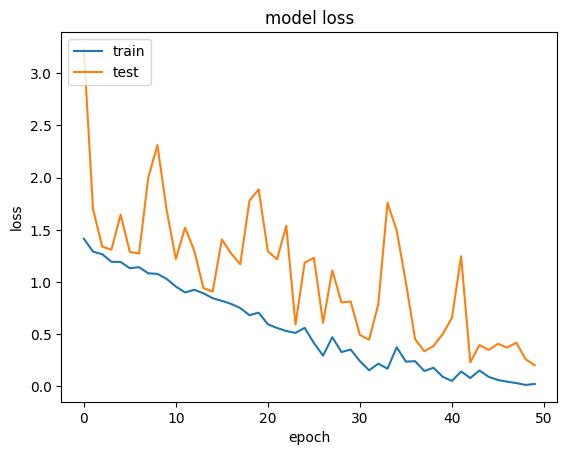

In [65]:

# Plotting the Train Valid Loss Graph
import matplotlib.pyplot as plt
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
# Saving the model.json

import json
model_json = model.to_json()
with open("/content/drive/My Drive/Project/Model.json", "w") as json_file:
    json_file.write(model_json)

In [67]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/Project/Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")

# # evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


## Predicting emotions on the test data

In [68]:
len(data2_df)

401

In [69]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i],duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 401/401 [00:16<00:00, 24.31it/s]


In [70]:
test_valid

array([[[-42.99339294],
        [-42.99339294],
        [-42.84764099],
        ...,
        [-42.99339294],
        [-42.99339294],
        [-42.99339294]],

       [[-62.08018494],
        [-62.08018494],
        [-62.08018494],
        ...,
        [-62.08018494],
        [-62.08018494],
        [-62.08018494]],

       [[-53.99901581],
        [-53.8647995 ],
        [-53.5544014 ],
        ...,
        [-54.01566315],
        [-54.07240295],
        [-54.07240295]],

       ...,

       [[-42.2259903 ],
        [-45.10041809],
        [-49.09457779],
        ...,
        [-44.11410904],
        [-45.35054398],
        [-47.55805969]],

       [[-50.66178513],
        [-51.4212265 ],
        [-52.99600601],
        ...,
        [         nan],
        [         nan],
        [         nan]],

       [[-65.80265808],
        [-65.80265808],
        [-65.80265808],
        ...,
        [         nan],
        [         nan],
        [         nan]]])

In [71]:
data_test

,feature
0,"[-42.993393, -42.993393, -42.84764, -42.269676..."
1,"[-62.080185, -62.080185, -62.080185, -62.08018..."
2,"[-53.999016, -53.8648, -53.5544, -53.88104, -5..."
3,"[-73.256584, -73.256584, -73.256584, -73.25658..."
4,"[-70.23107, -70.23107, -70.23107, -70.23107, -..."
...,...
396,"[-45.16223, -44.393044, -45.391006, -46.17963,..."
397,"[-64.74637, -61.184513, -65.279655, -66.382996..."
398,"[-42.22599, -45.100418, -49.094578, -50.658524..."
399,"[-50.661785, -51.421227, -52.996006, -56.03267..."


In [72]:
preds = model.predict(test_valid,
                         batch_size=16,
                         verbose=1)

26/26 [==============================] - 3s 99ms/step


In [73]:
preds

array([[9.9999851e-01, 5.1175939e-09, 4.2453340e-07, 9.2022918e-07,
        2.6567125e-11],
       [2.7219162e-03, 2.1717590e-03, 5.7227752e-04, 8.1199398e-03,
        9.8641419e-01],
       [9.5701134e-01, 4.0112156e-02, 2.2828032e-03, 4.2507780e-04,
        1.6845093e-04],
       ...,
       [6.6580845e-04, 3.1701438e-04, 4.0314062e-03, 9.8359072e-01,
        1.1395079e-02],
       [          nan,           nan,           nan,           nan,
                  nan],
       [          nan,           nan,           nan,           nan,
                  nan]], dtype=float32)

In [74]:
preds1=preds.argmax(axis=1)

In [75]:
preds1

array([0, 4, 0, 1, 4, 0, 0, 3, 1, 0, 0, 3, 4, 2, 2, 2, 4, 2, 2, 4, 3, 2,
       1, 2, 0, 1, 1, 1, 3, 0, 0, 4, 3, 1, 4, 3, 3, 2, 1, 1, 0, 0, 0, 0,
       3, 0, 2, 0, 1, 2, 4, 2, 1, 0, 3, 4, 0, 4, 4, 0, 3, 4, 0, 1, 3, 1,
       4, 4, 0, 1, 1, 3, 1, 4, 2, 2, 3, 1, 3, 3, 0, 0, 0, 3, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 3, 3, 2, 1, 0, 0, 0,
       4, 1, 0, 0, 0, 1, 1, 3, 3, 4, 3, 1, 3, 0, 1, 1, 2, 0, 4, 0, 4, 1,
       4, 0, 0, 2, 0, 1, 4, 1, 0, 4, 0, 1, 0, 3, 0, 3, 2, 2, 2, 1, 3, 0,
       0, 4, 3, 2, 4, 4, 3, 3, 0, 0, 0, 4, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 3, 0, 4, 0, 0, 0, 1, 1, 0, 0, 0, 3, 4, 1, 4, 0, 0, 0, 3,
       4, 0, 0, 1, 0, 0, 3, 0, 1, 0, 3, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 4,
       3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 4, 1, 0, 0, 4,
       4, 0, 0, 0, 2, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 1,
       1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0,

In [76]:
abc = preds1.astype(int).flatten()

In [77]:
print(abc)

[0 4 0 1 4 0 0 3 1 0 0 3 4 2 2 2 4 2 2 4 3 2 1 2 0 1 1 1 3 0 0 4 3 1 4 3 3
 2 1 1 0 0 0 0 3 0 2 0 1 2 4 2 1 0 3 4 0 4 4 0 3 4 0 1 3 1 4 4 0 1 1 3 1 4
 2 2 3 1 3 3 0 0 0 3 0 1 1 0 0 0 0 0 0 0 1 0 0 0 4 1 0 0 0 3 3 2 1 0 0 0 4
 1 0 0 0 1 1 3 3 4 3 1 3 0 1 1 2 0 4 0 4 1 4 0 0 2 0 1 4 1 0 4 0 1 0 3 0 3
 2 2 2 1 3 0 0 4 3 2 4 4 3 3 0 0 0 4 0 0 3 1 0 0 0 1 0 0 0 0 0 3 0 4 0 0 0
 1 1 0 0 0 3 4 1 4 0 0 0 3 4 0 0 1 0 0 3 0 1 0 3 0 4 0 0 0 0 0 1 0 0 4 3 0
 3 0 0 0 0 0 0 1 2 0 0 2 0 1 0 4 1 0 0 4 4 0 0 0 2 0 0 3 4 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 4 0 0 0 4 0 0 0 1 1 1 0 0 3 0 0 0 0 0
 0 3 4 0 0 1 1 0 2 0 0 0 3 0 1 1 0 1 0 1 0 0 1 0 0 3 4 1 1 3 3 4 1 0 3 3 2
 1 1 2 3 3 4 1 2 0 1 0 1 1 4 4 0 2 2 2 0 3 2 0 4 0 4 1 1 2 2 3 4 0 1 3 3 0
 2 4 4 0 0 0 0 1 0 2 1 0 4 1 1 0 3 0 2 4 2 1 4 3 2 0 2 0 3 0 0]


In [78]:
predictions = (lb.inverse_transform((abc)))

In [79]:
#Prediction of our given file at 400 index
predictions[400]

#The output is exact the same

'male_angry'

In [80]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,male_sad
2,male_angry
3,male_calm
4,male_sad
5,male_angry
6,male_angry
7,male_happy
8,male_calm
9,male_angry


In [81]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [82]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[::-10]

,actualvalues
400,male_sad
390,male_fearful
380,male_calm
370,male_fearful
360,male_calm
350,male_fearful
340,male_fearful
330,male_happy
320,male_angry
310,male_calm


In [83]:
finaldf = actualdf.join(preddf)


## Actual vs Predicted Values

In [84]:
finaldf[40:60]

,actualvalues,predictedvalues
40,male_fearful,male_angry
41,male_angry,male_angry
42,male_fearful,male_angry
43,male_angry,male_angry
44,male_happy,male_happy
45,male_angry,male_angry
46,male_fearful,male_fearful
47,male_fearful,male_angry
48,male_calm,male_calm
49,male_fearful,male_fearful


In [85]:
finaldf.groupby('actualvalues').count()


,predictedvalues
actualvalues,
male_angry,80
male_calm,80
male_fearful,80
male_happy,80
male_sad,81


In [86]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,183
male_calm,71
male_fearful,39
male_happy,55
male_sad,53


In [87]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [88]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

72.06982543640898

In [89]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

73.86538392901339

In [90]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[79,  1,  0,  0,  0],
       [15, 65,  0,  0,  0],
       [40,  1, 39,  0,  0],
       [24,  1,  0, 54,  1],
       [25,  3,  0,  1, 52]])

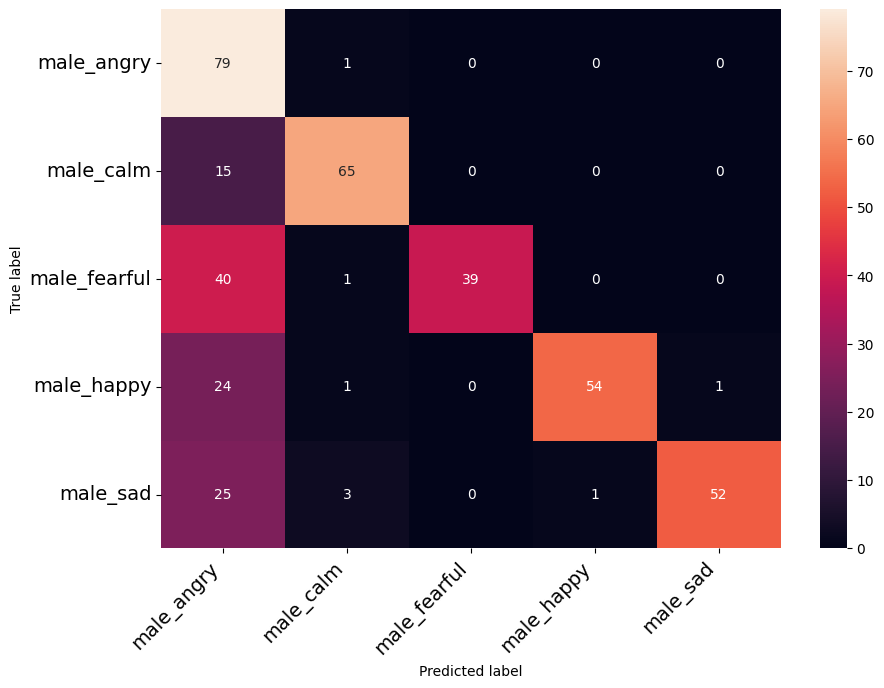

In [91]:
# Visualize Confusion Matrix

class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
#class_names1 = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
#class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
#class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

In [92]:
label=['male_sad','male_happpy','male_calm','male_angry','male_fearful']

In [93]:
my_data=pd.DataFrame(columns=['feature'])
X,samp=librosa.load('/content/drive/My Drive/Audio24/Actor_01/03-01-01-01-01-01-01.wav',duration=input_duration,sr=22050*2,offset=0.5)
samp=np.array(samp)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=samp, n_mfcc=13), axis=0)
feature = mfccs
my_data.loc[i]= [feature]
t_valid= pd.DataFrame(my_data['feature'].values.tolist())
t_valid=np.array(t_valid)
t_valid_lb=np.array(label)
lb1=LabelEncoder()
t_valid_lb=to_categorical(lb1.fit_transform(t_valid_lb))
t_valid=np.expand_dims(t_valid,axis=2)

In [102]:
import numpy as np

# Assuming t_valid is your input data with shape (None, 242, 1)
desired_length = 259
t_valid_padded = np.pad(t_valid, ((0, 0), (0, desired_length - t_valid.shape[1]), (0, 0)), mode='constant', constant_values=0)


In [103]:
my_preds=loaded_model.predict(t_valid_padded,
                         batch_size=16,
                         verbose=1)

1/1 [==============================] - 1s 1s/step


In [104]:
my_preds=loaded_model.predict(t_valid,
                         batch_size=16,
                         verbose=1)

1/1 [==============================] - 0s 350ms/step


In [105]:
my_preds

array([[2.6219969e-03, 2.3826154e-02, 3.6493246e-05, 1.8194962e-04,
        9.7333342e-01]], dtype=float32)

In [106]:
my_preds1=my_preds.argmax(axis=1)

In [107]:
my_abc=my_preds1.astype(int).flatten()
my_abc

array([4])

In [108]:
my_predictions = (lb1.inverse_transform((my_abc)))
my_predictions

array(['male_sad'], dtype='<U12')

In [109]:
#Prediction on second loaded data
label=['male_sad','male_happpy','male_calm','male_angry','male_fearful']
my_data=pd.DataFrame(columns=['feature'])
X,samp=librosa.load('/content/drive/MyDrive/Audio24/Actor_01/03-01-01-01-01-01-01.wav',duration=input_duration,sr=22050*2,offset=0.5)
samp=np.array(samp)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=samp, n_mfcc=13), axis=0)
feature = mfccs
my_data.loc[i]= [feature]
t_valid= pd.DataFrame(my_data['feature'].values.tolist())
t_valid=np.array(t_valid)
t_valid_lb=np.array(label)
lb1=LabelEncoder()
t_valid_lb=to_categorical(lb1.fit_transform(t_valid_lb))
t_valid=np.expand_dims(t_valid,axis=2)
my_preds=loaded_model.predict(t_valid,
                         batch_size=16,
                         verbose=1)
my_preds1=my_preds.argmax(axis=1)

my_abc=my_preds1.astype(int).flatten()
my_predictions = (lb1.inverse_transform((my_abc)))
print(my_predictions)


1/1 [==============================] - 0s 46ms/step
['male_sad']
